In [1]:
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import gc

In [2]:
file_path = "tifs/DOM_zjsru_ms-5bands_8cm.tif"

with rasterio.open(file_path) as src:
    image_array = src.read()  # shape: (bands, height, width)
    print(image_array.shape)  # (5, H, W) for a 5-band image

(5, 11942, 9338)


# Look at color ortophoto

In [3]:
rgb_array_split = np.clip(image_array[:3].copy(), 0, 1)
for i in range(3): # лучше нормализовать по отдельности
    rgb_array_split[i] = (rgb_array_split[i] - rgb_array_split[i].min()) / (rgb_array_split[i].max() - rgb_array_split[i].min())
rgb_array_split = (rgb_array_split * 255).astype(np.uint8)

In [4]:
if False:
    rgb_image_split = Image.fromarray(np.moveaxis(rgb_array_split, 0, -1)) # from (3, H, W) to (H, W, 3)
    rgb_image_split

In [5]:
# rgb_image_split = Image.fromarray(np.moveaxis(rgb_array_split, 0, -1)) # from (3, H, W) to (H, W, 3)
# rgb_image_split.save("rgb_image_split.jpg")

# Look at NDVI and EVI

In [5]:
ir_bands = np.clip(image_array[3:].copy(), 0, 2) # red edge and nir
for i in range(2):
    ir_bands[i] = (ir_bands[i] - ir_bands[i].min()) / (ir_bands[i].max() - ir_bands[i].min())
ir_bands = (ir_bands * 255).astype(np.uint8)

## NDVI

In [6]:
def compute_ndvi(red: np.ndarray, nir: np.ndarray):
    """
    Compute NDVI while handling division by zero.
    """
    # Convert to float to avoid integer division issues
    red = red.astype(np.float32)  
    nir = nir.astype(np.float32)
    # Compute NDVI safely
    denominator = nir + red
    ndvi = np.where(denominator == 0, -1, (nir - red) / denominator)  # Assign 0 where division is undefined
    
    return ndvi

def ndvi_to_grayscale(ndvi):
    # Normalize NDVI (-1 to 1) to (0 to 255) for grayscale
    ndvi_normalized = ((ndvi + 1) / 2 * 255).astype(np.uint8)  
    return Image.fromarray(ndvi_normalized)

In [7]:
ndvi = compute_ndvi(rgb_array_split[0], ir_bands[1])

/tmp/ipykernel_16216/3584187671.py:10: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(denominator == 0, -1, (nir - red) / denominator)  # Assign 0 where division is undefined


In [9]:
# display NDVI
# ndvi_image = ndvi_to_grayscale(ndvi)
# ndvi_image

In [8]:
if False:
    del ndvi_image
    gc.collect()

## EVI

In [9]:
def compute_evi(red: np.ndarray, blue: np.ndarray, nir: np.ndarray, L=1, C1=6, C2=7.5, G=2.5):
    """
    Compute EVI while handling division by zero.
    """
    # Convert to float to avoid integer division issues
    red = red.astype(np.float32) 
    nir = nir.astype(np.float32)
    blue = blue.astype(np.float32)
    # Compute NDVI safely
    denominator = nir + C1 * red - C2 * blue + L
    ndvi = np.where(denominator == 0, 0, G * (nir - red) / denominator)  # Assign 0 where division is undefined
    
    return ndvi

def evi_to_grayscale(evi):
    evi = np.clip(evi, -1, 3)  # Clip range
    evi_scaled = ((evi - evi.min()) / (evi.max() - evi.min()) * 255).astype(np.uint8)  # Scale to [0,255]
    return Image.fromarray(evi_scaled)

In [10]:
evi = compute_evi(rgb_array_split[0], rgb_array_split[2], ir_bands[1])

/tmp/ipykernel_16216/1157639335.py:11: RuntimeWarning: divide by zero encountered in divide
  ndvi = np.where(denominator == 0, 0, G * (nir - red) / denominator)  # Assign 0 where division is undefined
/tmp/ipykernel_16216/1157639335.py:11: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(denominator == 0, 0, G * (nir - red) / denominator)  # Assign 0 where division is undefined


In [11]:
evi_clipped = np.clip(evi, -5, 10)

In [12]:
# display EVI
# evi_image = evi_to_grayscale(evi)
# evi_image

In [13]:
if False:
    del evi_image
    gc.collect()

# Calculate metrics

In [14]:
# Load labeled points
labeled_points = pd.read_csv("labeled_points.csv")

# Convert to integer coordinates for indexing
labeled_points['x'] = labeled_points['x'].astype(int)
labeled_points['y'] = labeled_points['y'].astype(int)

In [17]:
# display evi with matplotlib, make figure size bigger
# plt.figure(figsize=(12, 10))
# plt.imshow(evi_clipped, cmap='viridis')
# plt.colorbar()
# plt.show()

In [15]:
# Ground truth labels: 1 = vegetation, 2 = non-vegetation
# Your prediction: class 1 if NDVI > threshold, else class 2
def compute_error_matrix(index_name, index_threshold=0.5):
    """Returns TP, TN, FP, FN"""
    index = ndvi if index_name == 'ndvi' else evi
    index_mask = index > index_threshold
    tp, tn, fp, fn = 0, 0, 0, 0
    # predictions = []
    for _, row in labeled_points.iterrows():
        x, y, label = row['x'], row['y'], row['label']
        predicted_label = 1 if index_mask[y, x] else 2
        # predictions.append(predicted_label)
        if predicted_label == 1:
            if predicted_label == label:
                tp += 1
            else:
                fp += 1
        elif predicted_label == 2:
            if predicted_label == label:
                tn += 1
            else:
                fn += 1
    return tp, tn, fp, fn


def compute_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    return accuracy, precision, recall


def find_best_threshold(index_name='ndvi'):
    index = ndvi if index_name == 'ndvi' else evi_clipped
    lower_bound, upper_bound = 0, index.max().astype(np.int32)
    threshold_values = [lower_bound + i * 0.01 for i in range(upper_bound * 100)]
    accuracy_values = []

    for thresh in tqdm(threshold_values):
        accuracy, precision, recall = compute_metrics(*compute_error_matrix(index_name, thresh))
        accuracy_values.append(accuracy)
    return threshold_values, accuracy_values


def visualize_error_matrix(tp, tn, fp, fn):
    # Create the confusion matrix as a 2x2 array
    confusion_matrix = np.array([[tp, fn],
                                [fp, tn]])

    # Labels for axes
    labels = ['Positive', 'Negative']

    # Plotting
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

### Best threshold for NDVI

In [16]:
threshold_values, accuracy_values = find_best_threshold(index_name='ndvi')

  0%|          | 0/100 [00:00<?, ?it/s]

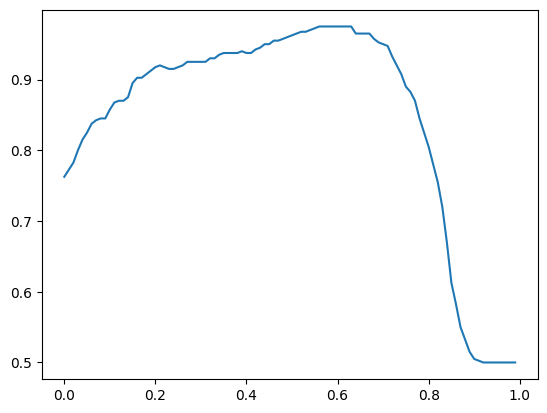

In [17]:
plt.plot(threshold_values, accuracy_values)

In [18]:
ndvi_df = pd.DataFrame({
    'threshold': threshold_values,
    'accuracy': accuracy_values
})
ndvi_df[ndvi_df['accuracy'] == ndvi_df['accuracy'].max()]

,threshold,accuracy
56,0.56,0.975
57,0.57,0.975
58,0.58,0.975
59,0.59,0.975
60,0.60,0.975
61,0.61,0.975
62,0.62,0.975
63,0.63,0.975


In [19]:
tp, tn, fp, fn =compute_error_matrix(index_name='ndvi', index_threshold=0.56)
accuracy, precision, recall = compute_metrics(tp, tn, fp, fn)
print(accuracy, precision, recall)

0.975 0.9797979797979798 0.97


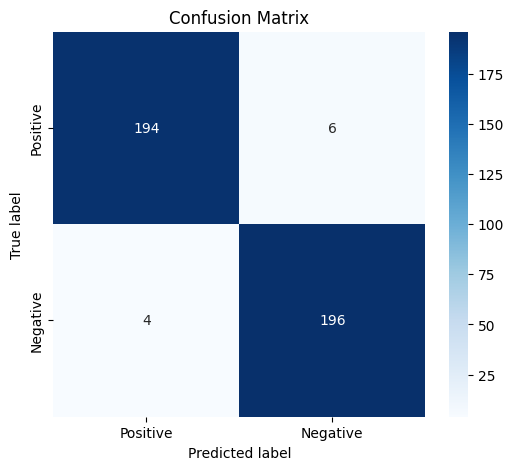

In [20]:
visualize_error_matrix(tp, tn, fp, fn)

### Best threshold for EVI

In [22]:
threshold_values, accuracy_values = find_best_threshold(index_name='evi')

  0%|          | 0/1000 [00:00<?, ?it/s]

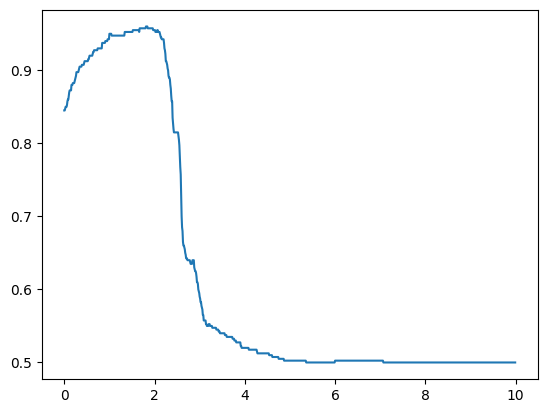

In [23]:
plt.plot(threshold_values, accuracy_values)

In [ ]:
evi_df = pd.DataFrame({
    'threshold': threshold_values,
    'accuracy': accuracy_values
})
evi_df[evi_df['accuracy'] == evi_df['accuracy'].max()]

,threshold,accuracy
181,1.81,0.96
182,1.82,0.96
183,1.83,0.96
184,1.84,0.96


In [29]:
tp, tn, fp, fn =compute_error_matrix(index_name='evi', index_threshold=1.82)
accuracy, precision, recall = compute_metrics(tp, tn, fp, fn)
print(accuracy, precision, recall)

0.96 0.9554455445544554 0.965


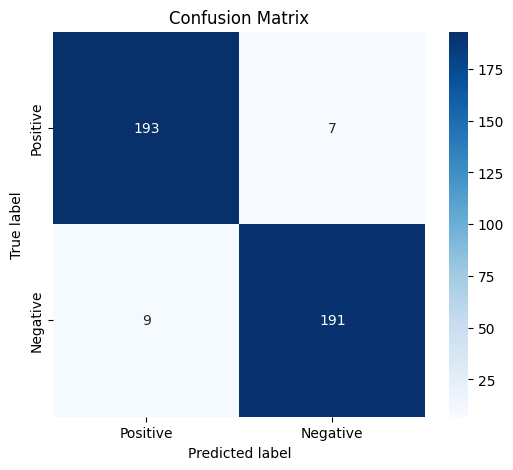

In [35]:
visualize_error_matrix(tp, tn, fp, fn)

# Visualize predictions

In [25]:
# ndvi_mask = ndvi > 0.56
# Image.fromarray(np.moveaxis(rgb_array_split * ndvi_mask, 0, -1))

/home/alexennk/anaconda3/envs/course/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (111514396 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


NameError: name 'predictions' is not defined

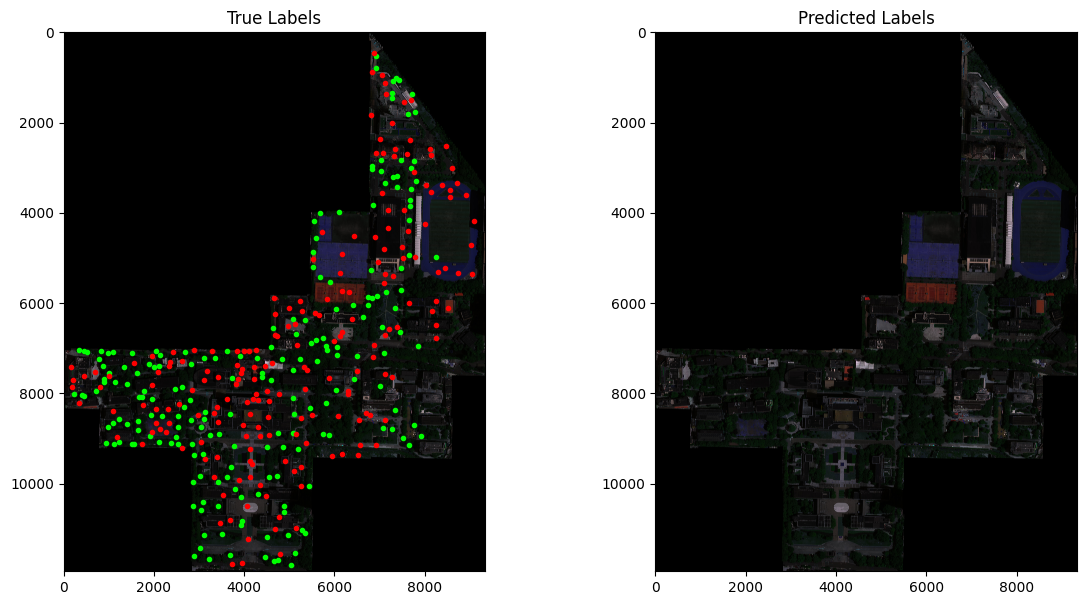

In [21]:
# Load original image
image = plt.imread('rgb_image_split.jpg')

# Load labeled data
df = labeled_points.copy()
coords = df[['x', 'y']].values
true_labels = df['label'].values

# Load or simulate predictions (just as an example: all 1s or threshold NDVI result)
# predictions = your_model_predictions  # replace with your actual prediction array
# For testing, let's simulate:
# predictions = np.random.choice([1, 2], size=len(true_labels))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# True Labels
axes[0].imshow(image)
axes[0].set_title('True Labels')
for (x, y), label in zip(coords, true_labels):
    color = 'lime' if label == 1 else 'red'
    axes[0].plot(x, y, 'o', color=color, markersize=3)

# Predictions
axes[1].imshow(image)
axes[1].set_title('Predicted Labels')
for (x, y), pred in zip(coords, predictions):
    color = 'lime' if pred == 1 else 'red'
    axes[1].plot(x, y, 'o', color=color, markersize=3)

plt.tight_layout()
plt.show()

# Calculate vegetation volume

In [40]:
def visualize_array_1d(input_array):
    array = input_array.copy()
    array = (array - array.min()) / (array.max() - array.min())
    array = (array * 255).astype(np.uint8)
    return Image.fromarray(array)

In [23]:
# visualize height map
file_path = "tifs/DSM_zjsru_op_8cm.tif"

with rasterio.open(file_path) as src:
    height_array = src.read()  # shape: (bands, height, width)
    print(height_array.shape)  # (5, H, W) for a 5-band image

(1, 11942, 9338)


In [47]:
height_array_final = height_array - height_array[height_array > 0].min()
height_array_final = np.clip(height_array_final, 0, height_array_final.max())

In [ ]:
# for visualization

# height_array_clipped = (height_array_clipped - height_array_clipped.min()) / (height_array_clipped.max() - height_array_clipped.min())
# height_array_clipped = (height_array_clipped * 255).astype(np.uint8)
# Image.fromarray(height_array_clipped[0])

In [48]:
# get vegetation height map

ndvi_mask = ndvi > 0.56
veg_height_map = height_array_final[0].copy() * ndvi_mask

In [59]:
height_array_final[0].sum() * 0.018 * 0.018

np.float32(147312.11)

## Calculate volume

In [57]:
(veg_height_map > 0).sum()

np.int64(16934268)

In [53]:
pixel_size = 0.018
veg_volume = veg_height_map.sum() * pixel_size ** 2

In [54]:
veg_volume

np.float32(54960.57)

In [60]:
54960 / 147312

0.3730856956663408